Давайте попробуем обучить нейронную сеть превращать яблоки в апельсины. Для этого нам понадобиться архитектура CycleGAN и датасет apple2orange. Для работы данного исходного кода необходим tensorflow 2.1.0.

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Подключение необходимых библиотек

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [3]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Предварительная обработка данных

Нам необходимо конвертировать изображения в `286 x 286` и случайно выбранные из них обрезать до `256 x 256`.

Кроме этого мы перевернем изображения горизонтально, т.е. слева на право.

Таким образом мы проведем процедуру похожую на image augmentation.

#### Загрузка датасета и донастройка параметров

In [5]:
dataset, metadata = tfds.load('Cycle_gan/apple2orange',
                              with_info=True, as_supervised=True)

train_apple, train_orange = dataset['trainA'], dataset['trainB']
test_apple, test_orange = dataset['testA'], dataset['testB']

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/3.0.0. Subsequent calls will reuse this data.


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

#### Подготовка данных

In [7]:
# случайное кадрирование
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# нормализация изображения [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # изменение размера 
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # кадрирование до  256 x 256 x 3
  image = random_crop(image)

  # произвольное вращение
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
# обработка изображений для обучения 
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
# обработка тестовых изображений
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [12]:
train_apple = train_apple.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_orange = train_orange.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_apple = test_apple.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_orange = test_orange.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
type(train_orange)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
sample_apple = next(iter(train_apple))
sample_orange = next(iter(train_orange))

In [15]:
sample_apple.shape

TensorShape([1, 256, 256, 3])

отрисовка изображений

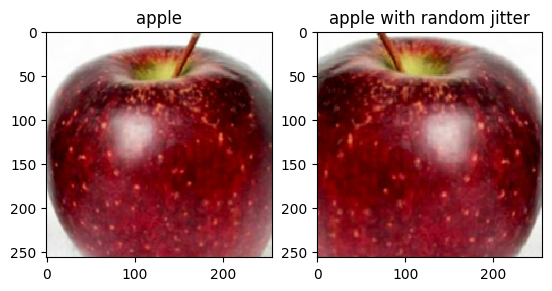

In [16]:
plt.subplot(121)
plt.title('apple')
plt.imshow(sample_apple[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('apple with random jitter')
plt.imshow(random_jitter(sample_apple[0]) * 0.5 + 0.5)

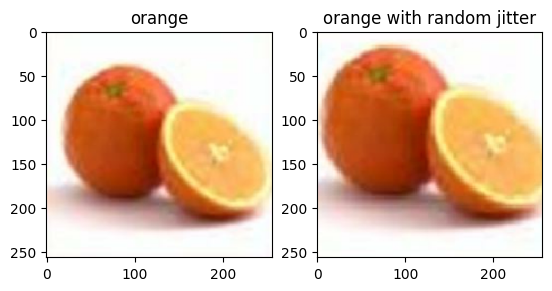

In [17]:
plt.subplot(121)
plt.title('orange')
plt.imshow(sample_orange[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('orange with random jitter')
plt.imshow(random_jitter(sample_orange[0]) * 0.5 + 0.5)

## Импортирование  Pix2Pix модели

Генератор и дискриминатор мы возьмем из Pix2Pix модели, генерация будет осуществляться с применением Unet.

In [18]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # яблоки в апельсины
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # апельсины в яблоки

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

смотрим как генератор создаем изображения из шума

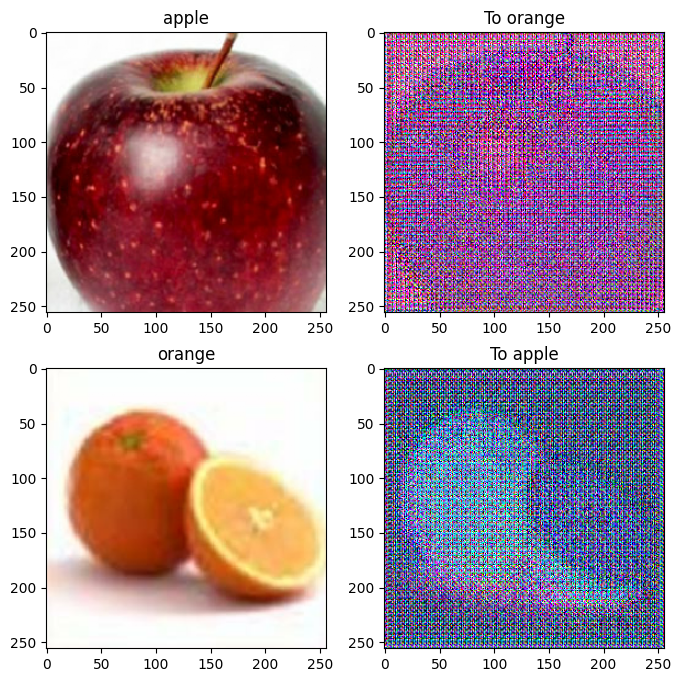

In [19]:
to_orange = generator_g(sample_apple)
to_apple = generator_f(sample_orange)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_apple, to_orange, sample_orange, to_apple]
title = ['apple', 'To orange', 'orange', 'To apple']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

смотрим, что оценивает дискриниматор, когда получает изображения от генератора

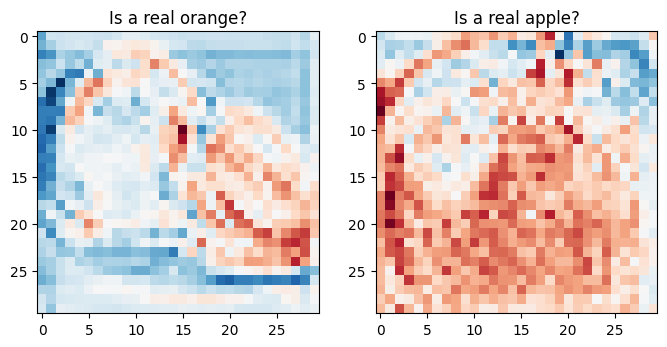

In [20]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real orange?')
plt.imshow(discriminator_y(sample_orange)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real apple?')
plt.imshow(discriminator_x(sample_apple)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

Loss функции для генератора и дискриминатора можно взять также из [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [21]:
LAMBDA = 10

In [22]:
# для дискриминатора
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
# дискриминатора проверяет реальное изображение с созданный генератором
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [24]:
# изображение созданное генератором
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [25]:
# разница между реальным и восстановленным изображением
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [26]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Инициализация оптимайзеров для всех генераторов и всех дискриминаторов.

In [27]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

Сохранение промежуточных результатов, для того, чтобы при необходимости можно было продолжить обучение, а не начинать сначала.

In [28]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Обучение

По умолчанию кол-во эпох выставлено 1 хотя, для корректного результатов понадобиться от 25 до 50

In [29]:
EPOCHS = 1

In [30]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Несмотря на то, что тренировочный процесс у GAN более сложный, он состоит из тех же этапов, что обычно:

* Получить предсказание
* Вычислить ошибку
* Посчитать градиенты используя обратное распространения ошибки.
* Применить градиенты для оптимайзера.

In [31]:
@tf.function
def train_step(real_x, real_y):

  with tf.GradientTape(persistent=True) as tape:
    # Генератор G переводит X -> Y
    # Генератор F переводит Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # нужны для подсчета потерь
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # подсчет потерь
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Общие потери генератора
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Рассчет градиентов для генератора и дискриминатора
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # применение градиентов в оптимизаторе
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

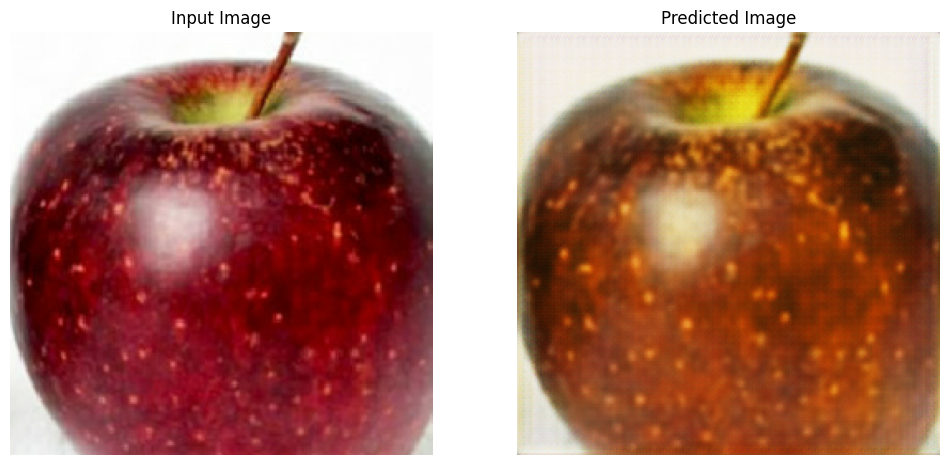

Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-1
Time taken for epoch 1 is 9690.20751953125 sec



In [32]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_apple, train_orange)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  generate_images(generator_g, sample_apple)

  if (epoch + 1) % 1 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Проверка модели на тестовых данных

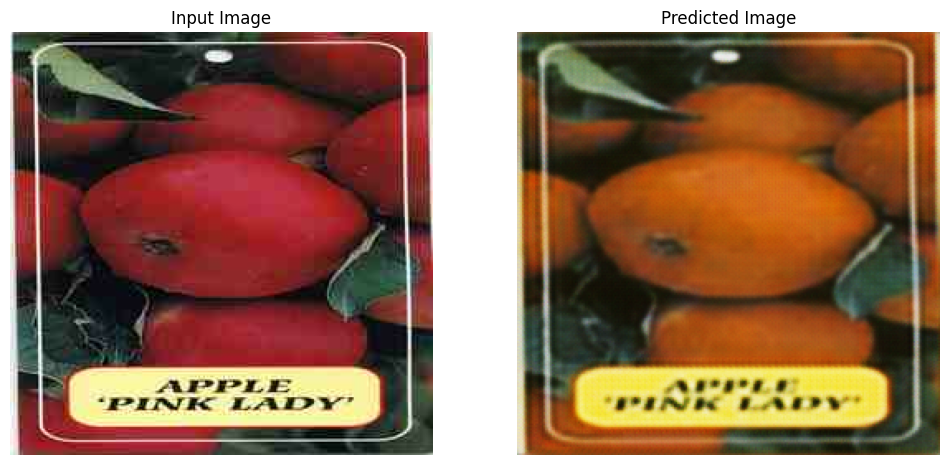

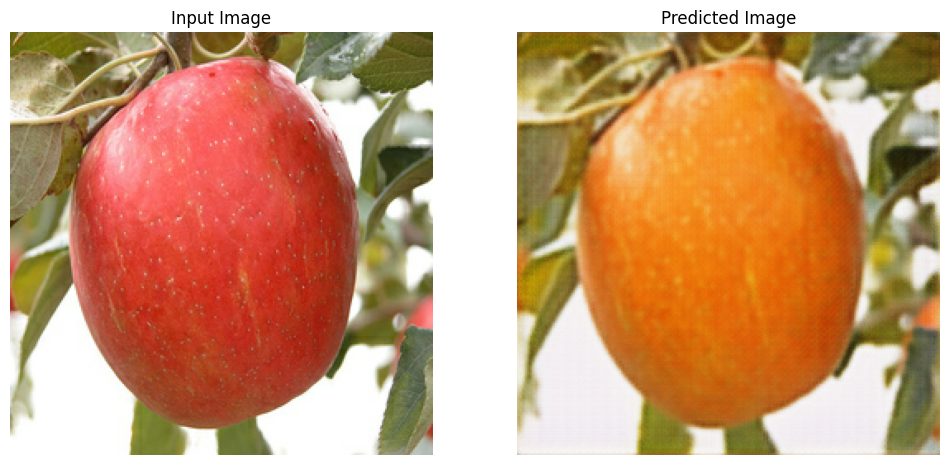

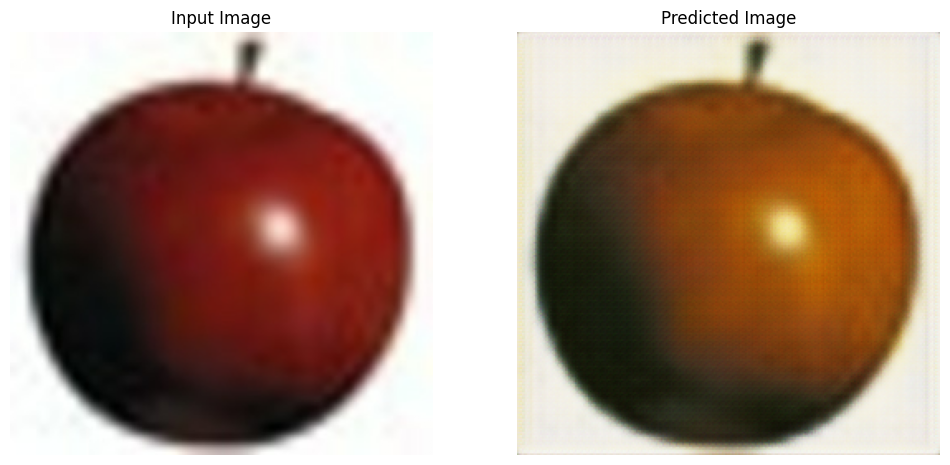

In [44]:
# Run the trained model on the test dataset
for inp in test_apple.take(3):
  generate_images(generator_g, inp)

Вывод: Модель очень "тяжелая" в обучении, поэтому провел всего одну эпоху, которая длилась около 2,5 часов. В результате мы получаем начало изменения изображения яблока на апельсин. Модель начинает менять общий цвет изображения на более оранжевый, что соответствует апельсину. Могу предположить, что изменение цвета займет еще 5-10 эпох, потом постепенно будет меняться структура кожуры (с гладкой на более ребристую). Не уверен, что модель успешно заменит плодонлжку (но это мое предположение). С генеративными моделями интересно работать, жаль только не хватает вычислительной мощности компьютера